In [16]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb # 勾配ブースティング
import seaborn as sns # オシャレなグラフ
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold

In [17]:
# データ読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 乗客のID
PassengerId = test['PassengerId']

# 最初の３行だけ見る
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [18]:
full_data = [train, test]

# 乗客の名前の長さ
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 客室番号データがあるなら１を、欠損値なら0を
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 家族の大きさを"タイタニックに同乗している兄弟/配偶者の数"と
# "タイタニックに同乗している親/子供の数"から定義
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# 家族がいるかどうか
# いるなら"IsAlone"が１
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# 出港地の欠損値を一番多い"S"としておく
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# 料金の欠損値を中央値としておく
# 料金の大きく４つのグループに分ける
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# 年齢を５つのグループに分ける
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 名前を取り出す関数１
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # 名前があれば取り出して返す
    if title_search:
        return title_search.group(1)
    return ""

# 関数１を使う
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# 名前の変なところを変換
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # 女なら０、男なら１
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # 名前の5種類にラベル付
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # 出港地の3種類にラベル付
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # 料金を４つのグループに分ける
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # 年齢を5つのグループに分ける
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

# 必要ない特徴を削除
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [19]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


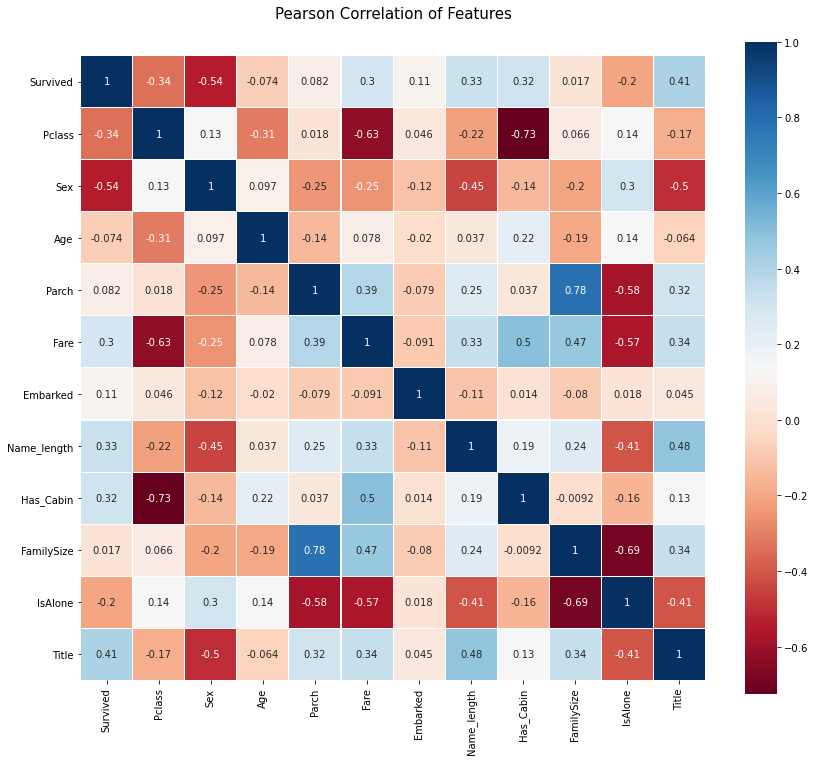

In [20]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

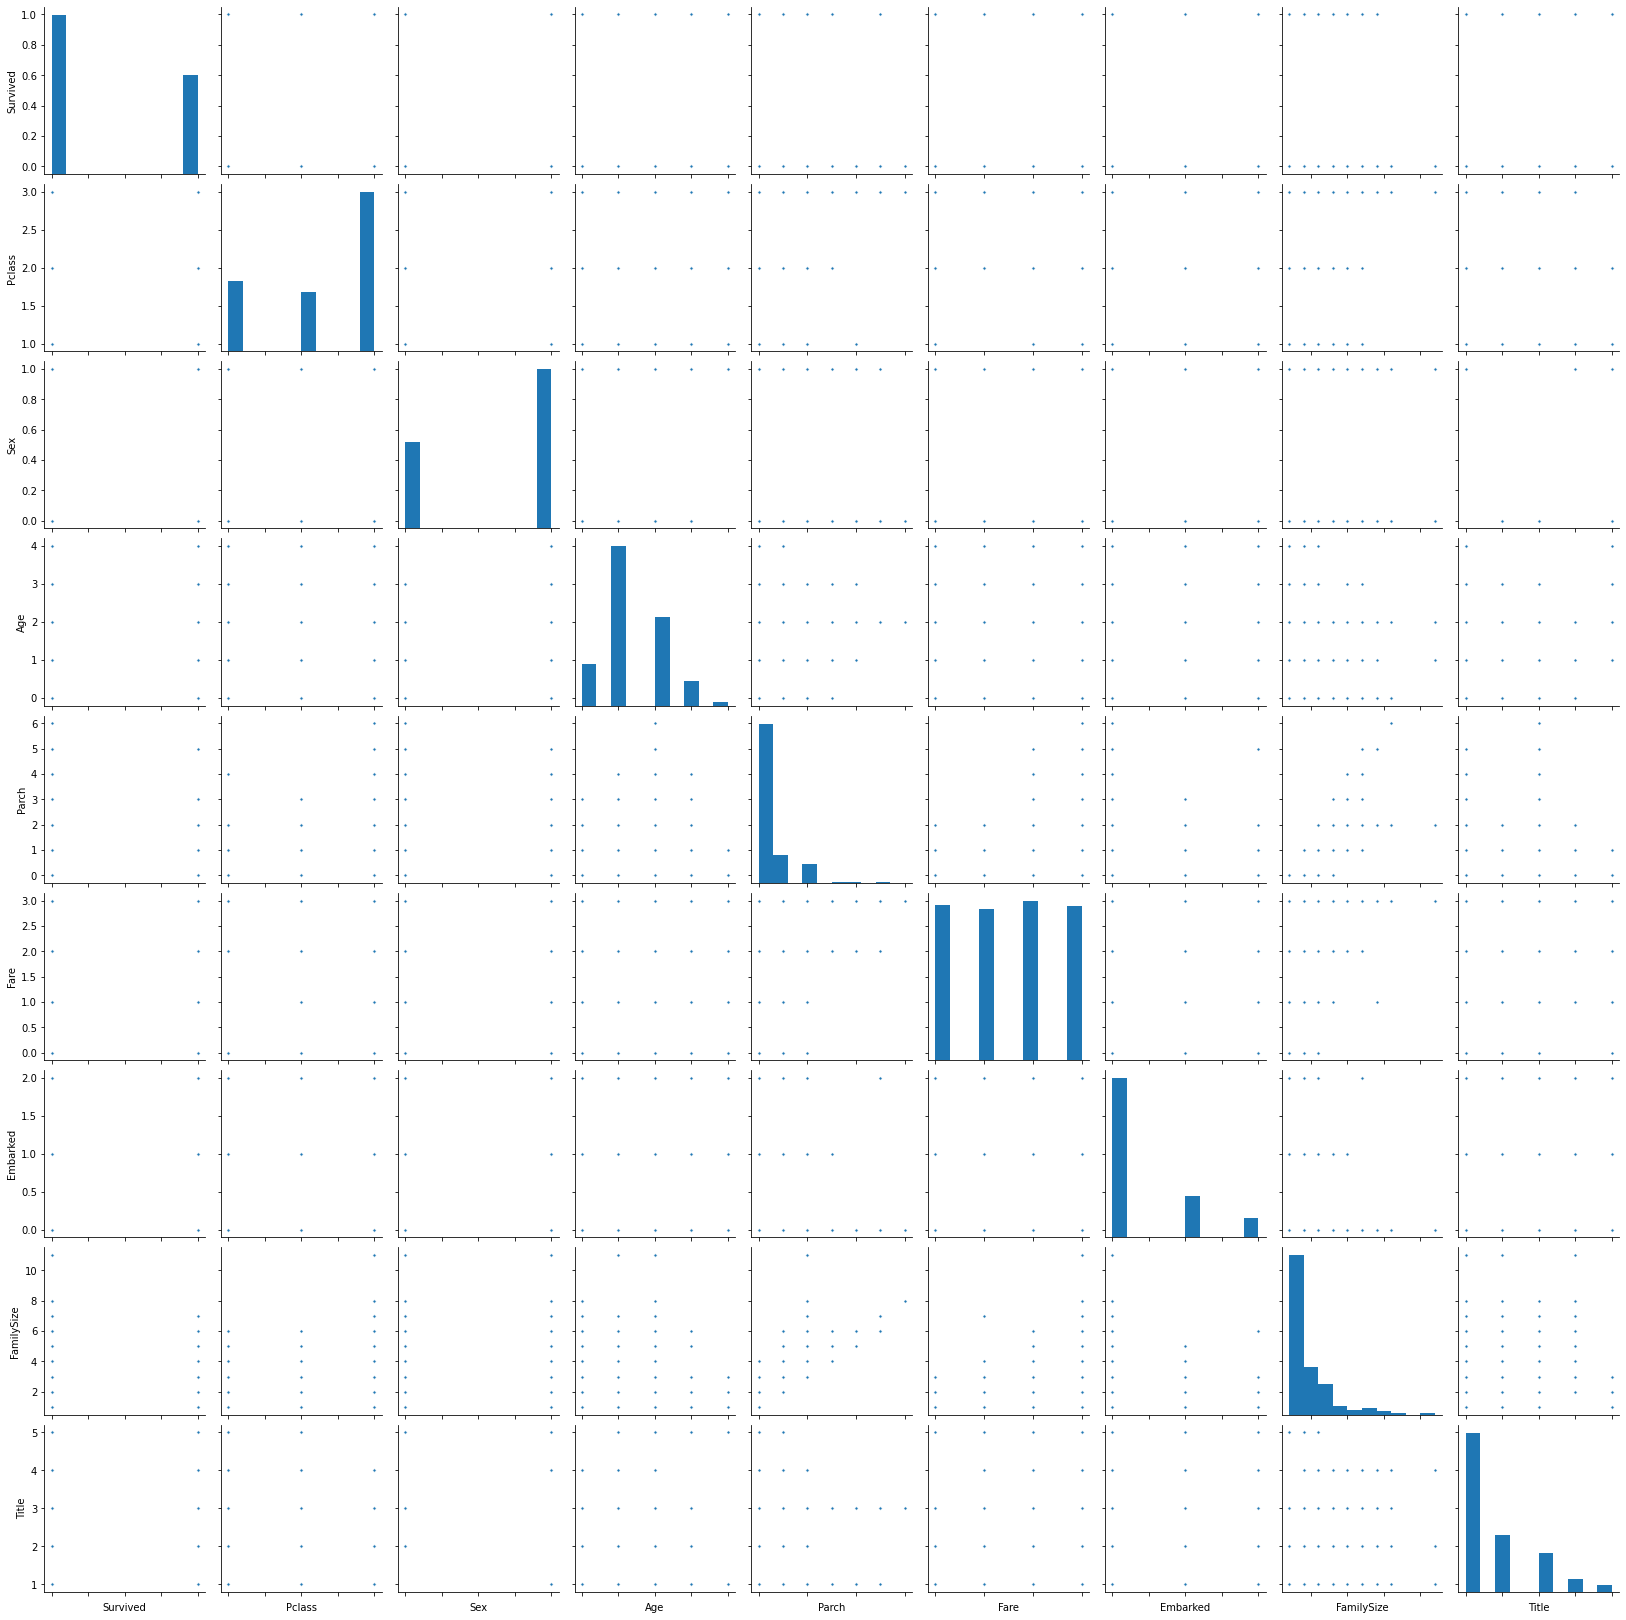

In [39]:
'''
g = sns.pairplot(train[[u'Survived',
                        u'Pclass',
                        u'Sex', 
                        u'Age', 
                        u'Parch', 
                        u'Fare', 
                        u'Embarked',
                        u'FamilySize', 
                        u'Title']],
                 hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
'''
g = sns.pairplot(train[[u'Survived',
                        u'Pclass',
                        u'Sex', 
                        u'Age', 
                        u'Parch', 
                        u'Fare', 
                        u'Embarked',
                        u'FamilySize', 
                        u'Title']],
                 plot_kws=dict(s=10) )

g.set(xticklabels=[])


In [43]:
# パラメータ
ntrain = train.shape[0] # 891
ntest = test.shape[0] # 418
SEED = 0
NFOLDS = 5 # 5分割
kf = KFold(n_splits= NFOLDS, random_state=SEED)
kf.get_n_splits(ntrain)

# Sclearn分類機を拡張
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self,x,y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [44]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf): # NFOLDS回まわる
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [45]:
# 各モデルのパラメータ
# Random Forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [46]:
# 5つの学習モデルのオブジェクトを作成
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [47]:
# 入力データの作成
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # 学習データ
x_test = test.values # テストデータ

In [48]:
# 5つのベースモデルで予測
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees Classifier
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest Classifier
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost Classifier
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost Classifier
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

TypeError: 'KFold' object is not iterable